In [1]:
# Load & query database
import sqlite3
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

/Users/zhaleh/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)

## 1. Querying Data & Exploratory Data Analysis

In [4]:
query = """SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;"""

In [5]:
query = """SELECT * FROM 'OrderDetail';"""

In [6]:
cur.execute(query)
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [7]:
"Total data points: {}, unique orders: {}, unique products: {}".format(len(df), df.OrderId.nunique(), df.ProductId.nunique())

'Total data points: 2155, unique orders: 830, unique products: 77'

In [8]:
df.groupby('Discount').Quantity.describe()

,count,mean,std,min,25%,50%,75%,max
Discount,,,,,,,,
0.00,1317.0,21.715262,17.507493,1.0,10.0,18.0,30.0,130.0
0.01,1.0,2.000000,NaN,2.0,2.0,2.0,2.0,2.0
0.02,2.0,2.000000,1.414214,1.0,1.5,2.0,2.5,3.0
0.03,3.0,1.666667,0.577350,1.0,1.5,2.0,2.0,2.0
0.04,1.0,1.000000,NaN,1.0,1.0,1.0,1.0,1.0
0.05,185.0,28.010811,22.187685,1.0,14.0,20.0,40.0,120.0
0.06,1.0,2.000000,NaN,2.0,2.0,2.0,2.0,2.0
0.10,173.0,25.236994,21.186503,2.0,10.0,20.0,30.0,130.0
0.15,157.0,28.382166,20.923099,2.0,15.0,21.0,40.0,100.0


Since there are very few examples for discounts of 1%-6% (excluding 5%) it makes sense to drop these. Additionally these are odd reduction amounts that are not commonly occuring. Usually, people think in terms of 5 % increments.

In [9]:
df = df[~df.Discount.isin([0.01, 0.02, 0.03, 0.04, 0.06])]

In [10]:
discount_df = df[df.Discount != 0]
fullprice_df = df[df.Discount == 0]

In [11]:
len(fullprice_df), len(discount_df)

(1317, 830)

In [12]:
product_ids = list(discount_df.ProductId.unique())
product_ids.sort()

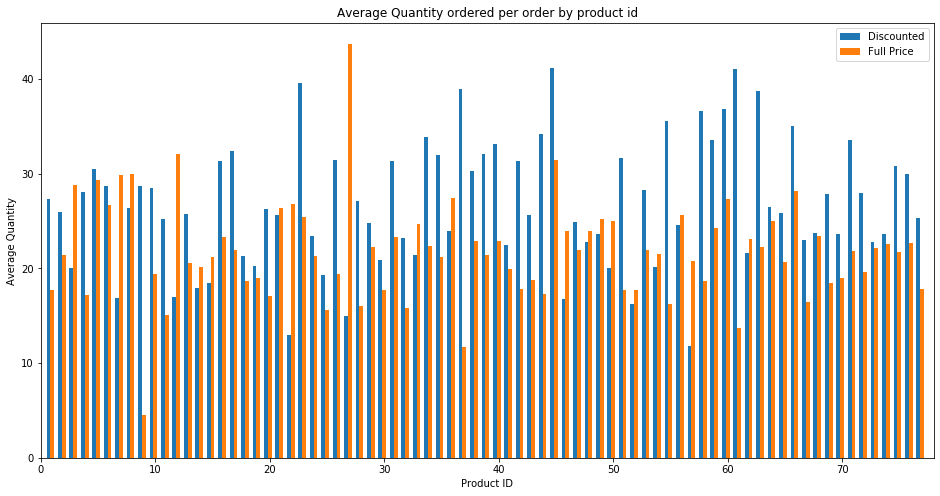

In [13]:
plt.figure(figsize=(16,8))

width = np.min(np.diff(product_ids))/3
plt.bar(product_ids - width, discount_df.groupby('ProductId').Quantity.mean(), width, label='Discounted')
plt.bar(product_ids, fullprice_df.groupby('ProductId').Quantity.mean(), width, label='Full Price')
plt.xlim(0, max(product_ids)+1)
plt.legend()
plt.title("Average Quantity ordered per order by product id")
plt.xlabel('Product ID')
plt.ylabel("Average Quantity")
plt.show();

The graph above shows each product and the average quantity ordered per order, when the item was discounted (in blue) vs. when the item was not discounted (in orange). Very often it seems as if more quantities were ordered when the item was discounted. However, there are some cases where this isn't the case. We need to further investigate to see if we can safely say that discounting a product encourages buying more of the product.

### Mean and SD of discount vs. full price orders

In [14]:
print("Mean quantity in full price orders {} vs. discounted: {}".format(round(fullprice_df.Quantity.mean(), 1)
                                                                         ,round(discount_df.Quantity.mean(),1)))
print("SD full price {} vs. discounted {}".format(round(np.std(fullprice_df.Quantity),1 ),
                                                    round(np.std(discount_df.Quantity),1 ) ))

Mean quantity in full price orders 21.7 vs. discounted: 27.4
SD full price 17.5 vs. discounted 20.7


Taking a look at the mean values and total values, we can see that on average people order more when the item is discounted (by around ~6 more), than when full price. Below, total sum of quantity ordered is more for full price, however this may simply be a relic of there being more orders for full price items. Perhaps, the items were discounted during only a limited period.

In [15]:
fullprice_df.Quantity.sum(), discount_df.Quantity.sum()

(28599, 22704)

In [16]:
import warnings
warnings.filterwarnings("ignore")

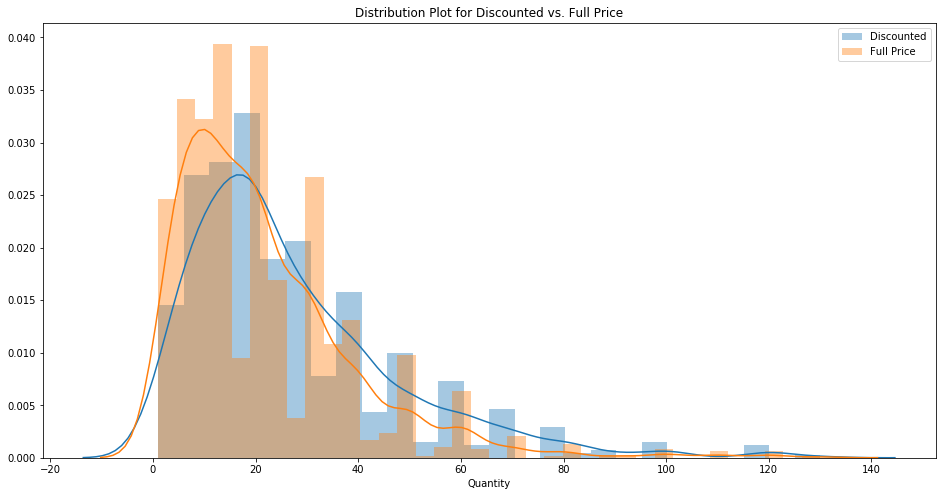

In [17]:
plt.figure(figsize=(16,8))
sns.distplot(discount_df.Quantity, label='Discounted')
sns.distplot(fullprice_df.Quantity, label='Full Price').set_title("Distribution Plot for Discounted vs. Full Price")
plt.legend()
plt.show();

Plotting the distribution of the two sets of full price vs. discounted, we see there is a tail on orders with large quantities and a skew towards ordering fewer quantities. Below we test for normal distribution to know whether to assume normal distribution of data.

### **Checking for normal distributions**
There is no difference between sample & hypothetical normal distribution.

**Acceptance Criteria**: If the calculated value is less than the critical value, accept the null hypothesis.  
**Rejection Criteria**: If the calculated value is greater than the critical value, reject the null hypothesis.

We can use KS Test to test for normal distribution.

In [18]:
#KS test to see if the data comes from the same distributions
print(stats.kstest(discount_df.Quantity, 'norm', args=(discount_df.Quantity.mean(), discount_df.Quantity.std()))) 
print(stats.kstest(fullprice_df.Quantity, 'norm',
                   args=(fullprice_df.Quantity.mean(), fullprice_df.Quantity.std() )))


KstestResult(statistic=0.1540171703044333, pvalue=1.1697194236207052e-17)
KstestResult(statistic=0.1571445192364258, pvalue=7.148467674601979e-29)


The p-values for both sets of data are 0, which means that we can reject the null hypothesis that the ditribution is normal. This means we should use Welch's T-test which does not assume equal variances.

### Checking difference in distributions between two datasets
There is no difference between the two dataset's distribution

In [19]:
print(stats.ks_2samp(fullprice_df.Quantity,discount_df.Quantity))

Ks_2sampResult(statistic=0.1283896405668231, pvalue=8.846005317142414e-08)


The third test, tests whether the distribution of the sets differ from each other. The p-value is less than 0.05 which means they come from the same distribution.

### Hypothesis 1
**Question**: From the graph above, we suspect that there is a difference in quantity of items ordered when the item is discounted vs. full price. Here we investigate whether this is true  
**H0**: There is no difference in quantity of items ordered when there is a discount vs. full price.  
**H1**: There is an increase in quantity of items ordered when there is a discount.

Here we use Welch's T-test for difference between the groups, since we do not assume normal distribution.

In [20]:
#when equal_var=False, welch's t test is used
t, p = stats.ttest_ind(discount_df.Quantity, fullprice_df.Quantity, equal_var=False) 

In [21]:
if p < 0.025:
    print("Reject null hypothesis. There is an increase in quantity ordered when there is a discount.")
else:
    print("There is an incrase in the quantity ordered when there is a discount.")
print("T-stat: {}, p-value: {}".format(round(t,2), p))

Reject null hypothesis. There is an increase in quantity ordered when there is a discount.
T-stat: 6.51, p-value: 1.0051255540843165e-10


### **Hypothesis 2**
**Question**: Is amount of discount significant in predicting quantity of the item per order?  
**H0**: There is no significant difference in quantity of orders based on the amount of discount.  
**H1**: There is no significant difference in quantity of orders based on the amount of discount.

Here we use ANOVA to whether the different discount groups (different amounts) is significant in quantity ordered

In [22]:
# Your code here
formula = 'Quantity ~ C(Discount)'
lm = ols(formula,df).fit() 
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                    sum_sq      df         F        PR(>F)
C(Discount)   17348.854662     5.0  9.798709  2.840681e-09
Residual     758138.565924  2141.0       NaN           NaN


Treating each discount group as a categorical variable, and using an anova to test the multiple categories, we get a p-value less than 0.05. This means we can reject the null hypothesis and amount of discount is significant in order quantity 

### **Hypothesis 2(a):**  At what price is discount significant?
To determine at which discount amount is significant in predicting quantity, we can build a baseline linear regression model, with a categorical vairable for discount amount to investgiate the effect of each group.

In [23]:
df_ols = pd.get_dummies(df, columns=['Discount'], prefix=["discount"])
X = df_ols.drop(['Id', 'OrderId', 'ProductId'], axis=1)
new_columns = []
for x in X.columns:
    x = x.replace(".", '')
    new_columns.append(x)
X.columns = new_columns
X.head()

,UnitPrice,Quantity,discount_00,discount_005,discount_01,discount_015,discount_02,discount_025
0,14.0,12,1,0,0,0,0,0
1,9.8,10,1,0,0,0,0,0
2,34.8,5,1,0,0,0,0,0
3,18.6,9,1,0,0,0,0,0
4,42.4,40,1,0,0,0,0,0


In [24]:
outcome = 'Quantity'
predictors = X.drop(columns=['Quantity', 'UnitPrice']).columns
f = '+'.join(predictors)
formula = outcome + '~' + f
stats_model = ols(formula=formula, data=X).fit()

In [25]:
stats_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Quantity   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     9.799
Date:                Thu, 25 Feb 2021   Prob (F-statistic):           2.84e-09
Time:                        15:19:06   Log-Likelihood:                -9344.5
No. Observations:                2147   AIC:                         1.870e+04
Df Residuals:                    2141   BIC:                         1.873e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.6586      0.473     47.858      0.000      21.730      23.587
discount_00     -0.9434      0.645     -1.462      0.144      -2.209       0.322
discount_005     5.3522      1.261      4.243      0.000       2.878       7.826
discount_01      2.5784      1.299      1.986      0.047       0.032       5.125
discount_015     5.7235      1.355      4.225      0.000       3.067       8.380
discount_02      4.3662      1.340      3.259      0.001       1.739       6.994
discount_025     5.5816      1.366      4.085      0.000       2.902       8.261
==============================================================================
Omnibus:                      784.809   Durbin-Watson:                   1.643
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3071.552
Skew:                           1.770   Prob(JB):                         0.00
Kurtosis:                       7.670   Cond. No.                     1.55e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.31e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Here we can see that all discounts from 5%-25% are significant in predicting quantity ordered. However, the coefficients show that 10% discount has less of an effect.

In [26]:
#TUKEY TEST
tukey_df = df[['Discount', 'Quantity']]
tukey_df['Discount'] = tukey_df.Discount.astype(str, copy=False)
tukey_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2147 entries, 0 to 2154
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Discount  2147 non-null   object
 1   Quantity  2147 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 50.3+ KB


In [27]:
MultiComp = MultiComparison(tukey_df['Quantity'],
                            tukey_df['Discount'])
print(MultiComp.tukeyhsd().summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.0   0.05   6.2955  0.001  2.0814 10.5097   True
   0.0    0.1   3.5217 0.1885 -0.8187  7.8622  False
   0.0   0.15   6.6669  0.001  2.1352 11.1986   True
   0.0    0.2   5.3096 0.0096  0.8285  9.7907   True
   0.0   0.25    6.525  0.001   1.954  11.096   True
  0.05    0.1  -2.7738  0.704 -8.4504  2.9028  False
  0.05   0.15   0.3714    0.9 -5.4528  6.1955  False
  0.05    0.2   -0.986    0.9 -6.7708  4.7989  False
  0.05   0.25   0.2294    0.9 -5.6253  6.0842  False
   0.1   0.15   3.1452 0.6333  -2.771  9.0613  False
   0.1    0.2   1.7879    0.9 -4.0896  7.6653  False
   0.1   0.25   3.0033  0.677  -2.943  8.9496  False
  0.15    0.2  -1.3573    0.9 -7.3775  4.6628  False
  0.15   0.25  -0.1419    0.9 -6.2292  5.9454  False
   0.2   0.25   1.2154    0.9 -4.8343  7.2652  False
----------------------------------------------

With the exception of 10%, any discount is better than a 0/full price offering. However, there is no significant difference between each of the discount groups. This suggests that if one would like to maximize their profits. The business could give the smallest significant discount: 5%. However, 15% has the largest difference in quantity ordered at 6.7 more items ordered.

### **Hypothesis 3**

**Question** is there an interaction between unit price & discount? The idea is that some low cost items (for example, paper clips) a 5 vs. 25 % discount will be just a few pennies or maybe a dollar.  
First, let's look more closely at the unit price feature.

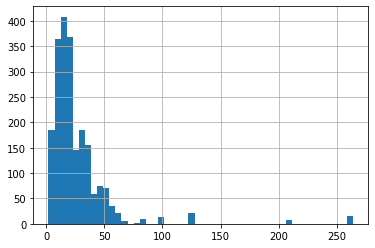

In [28]:
df['UnitPrice'].hist(bins = 50)

Looking at the histogram, we could partition the data into three bins, indicating lower cost, medium, and higher cost items. I chose to categorize into bins of unit prices less than \\$25, \\$25-50, and greater than \\$50

In [29]:
less_25_df = df[df['UnitPrice'] < 25]
twentyfive_50_df = df[(df['UnitPrice'] >= 25) & (df['UnitPrice'] < 50)]
greater_50_df = df[df['UnitPrice'] >= 50]

In [30]:
less_25_model = LinearRegression()
twenty_50_model = LinearRegression()
grater_50_model = LinearRegression()

x_less_25 = less_25_df['Discount'].values.reshape(-1,1)
y_less_25 = less_25_df['Quantity'].values.reshape(-1,1)

x_25_50 = twentyfive_50_df['Discount'].values.reshape(-1,1)
y_25_50 = twentyfive_50_df['Quantity'].values.reshape(-1,1)

x_50_greater = greater_50_df['Discount'].values.reshape(-1,1)
y_50_greater = greater_50_df['Quantity'].values.reshape(-1,1)

less_25_model.fit(x_less_25, y_less_25)
twenty_50_model.fit(x_25_50, y_25_50)
grater_50_model.fit(x_50_greater, y_50_greater)

pred_1 = less_25_model.predict(x_less_25)
pred_2 = twenty_50_model.predict(x_25_50)
pred_3 = grater_50_model.predict(x_50_greater)

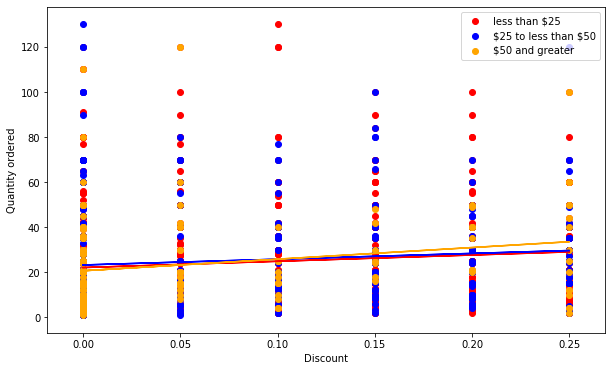

In [31]:
plt.figure(figsize=(10,6))
plt.scatter(x_less_25, y_less_25, label='less than $25', c='red')
plt.scatter(x_25_50, y_25_50, label='\$25 to less than \$50', c='blue')
plt.scatter(x_50_greater, y_50_greater, label='$50 and greater',c='orange')

plt.plot(x_less_25, pred_1, c='red')
plt.plot(x_25_50, pred_2, c='blue')
plt.plot(x_50_greater, pred_3, c='orange')
plt.xlabel('Discount')
plt.ylabel('Quantity ordered')
plt.legend()
plt.show();

This graph plots regression lines for the three bins of cost. It's difficult to see whether high cost items are lower or the same as the other categories when discount amount is low. So the graph below zooms in.

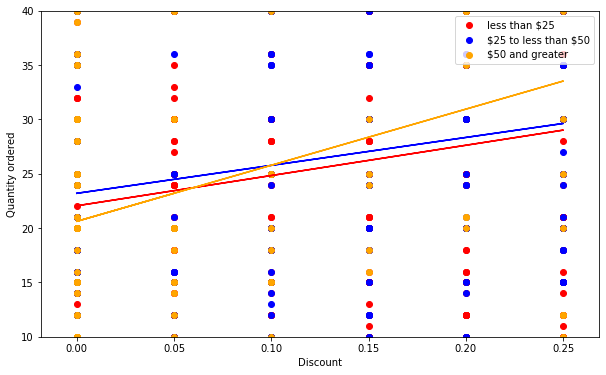

In [32]:
plt.figure(figsize=(10,6))
plt.scatter(x_less_25, y_less_25, label='less than $25', c='red')
plt.scatter(x_25_50, y_25_50, label='\$25 to less than \$50', c='blue')
plt.scatter(x_50_greater, y_50_greater, label='$50 and greater',c='orange')

plt.plot(x_less_25, pred_1, c='red')
plt.plot(x_25_50, pred_2, c='blue')
plt.plot(x_50_greater, pred_3, c='orange')
plt.xlabel('Discount')
plt.ylabel('Quantity ordered')
plt.ylim(10, 40)
plt.legend()
plt.show();

We can see here that there is an interaction between discount & unit price. at 5\% discount the items that are greater than \\$50 have fewer quantities ordered than the other two categories, at 10\% the same as those that are \\$25 - 50, and then after 15\% is surpasses the other two categories. This makes sense as a larger discount on a more expensive items, means the total dollar savings will be greater. 

#### Build an interaction model to determine whether interaction is significant.

In [33]:
X_interact_categorical = X.drop(columns=['Quantity']).copy()
X_interact_categorical['UnitPrice_Discount'] = df['UnitPrice'] * df['Discount']

In [34]:
y = X['Quantity']

In [35]:
X_interact_categorical = sm.add_constant(X_interact_categorical)
model = sm.OLS(y,X_interact_categorical)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Quantity   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     7.296
Date:                Thu, 25 Feb 2021   Prob (F-statistic):           1.14e-08
Time:                        15:19:22   Log-Likelihood:                -9343.4
No. Observations:                2147   AIC:                         1.870e+04
Df Residuals:                    2139   BIC:                         1.875e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 22.1304      0.640     34.565      0.000      20.875      23.386
UnitPrice             -0.0073      0.016     -0.453      0.650      -0.039       0.024
discount_00           -0.2249      0.833     -0.270      0.787      -1.859       1.409
discount_005           5.7175      1.299      4.402      0.000       3.170       8.265
discount_01            2.6574      1.301      2.043      0.041       0.107       5.208
discount_015           5.5532      1.360      4.083      0.000       2.886       8.220
discount_02            3.8837      1.383      2.809      0.005       1.173       6.595
discount_025           4.5435      1.547      2.937      0.003       1.509       7.578
UnitPrice_Discount     0.2511      0.179      1.401      0.161      -0.100       0.603
==============================================================================
Omnibus:                      786.913   Durbin-Watson:                   1.646
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3094.777
Skew:                           1.773   Prob(JB):                         0.00
Kurtosis:                       7.692   Cond. No.                     6.01e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.41e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

The interaction is not significant. 

### Cross-Validation on Baseline & Interaction models

In [36]:
regression_baseline = LinearRegression()
crossvalidation = KFold(n_splits=3, shuffle=True, random_state=1)


baseline = np.mean(cross_val_score(regression_baseline, X.drop(columns=['Quantity']), y, scoring='r2', cv=crossvalidation))
baseline

0.013966779565708095

In [37]:
regression_interact = LinearRegression()

interact_model_score = np.mean(cross_val_score(regression_interact, X_interact_categorical, y, scoring='r2', cv=crossvalidation))
interact_model_score

0.013715108304171478

Consistent with the interaction of price & discount amount, cross-validation shows that includng the interaction does not yield in a better model. (R2 score is best fit, so larger is better)

### **Hypothesis 4**

Some products you don't need a lot of and therefore you wouldn't buy more in one order despite their being a discount. For example, you would only buy 1 fridge regardless if it's on sale. (You might wait to buy it when it's on discount but short of being a contractor who installs fridges, you wouldn't buy more than 1). In contrast, if some canned food was on sale, you might buy a few extra cans since they won't go bad too quickly.  
  
**H0** Product Id & discount is not significant in predicting quantity ordered.  
**H1** Product Id & discount is significant in predicting quantity ordered.

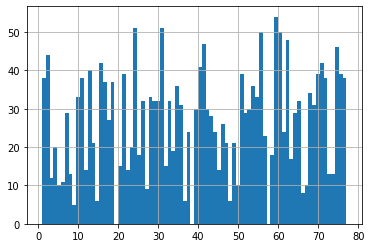

In [38]:
df['ProductId'].hist(bins = 80)

In [39]:
df_product = df.groupby('ProductId').agg({'Quantity':[('quantity_avg', 'mean'), 
                                                     ('quantity_sum', 'sum'),
                                                    ('quantity_max', 'max')]}) # max_height=('height', 'max'), min_weight=('weight', 'min')

In [40]:
df_product

Quantity                          
          quantity_avg quantity_sum quantity_max
ProductId                                       
1            21.789474          828           80
2            24.022727         1057          100
3            27.333333          328           60
4            22.650000          453           50
5            29.800000          298           70
...                ...          ...          ...
73           22.384615          291           50
74           22.846154          297           50
75           25.108696         1155          120
76           25.153846          981           90
77           20.815789          791           70

[77 rows x 3 columns]

In [41]:
df_product['Quantity']['quantity_avg'].max(), df_product['Quantity']['quantity_avg'].min(),

(40.55555555555556, 17.24137931034483)

Product with the highest average quantity is 40 units, while the lowest average is 17.

In [42]:
df_product['Quantity']['quantity_max'].max(), df_product['Quantity']['quantity_max'].min()

(130, 40)

The product that has the highest maximal quantity in an order has 130 units, vs. the product who's max order is the least w.r.t. other products is at 40 units

In [43]:
formula = 'Quantity ~ C(ProductId) * C(Discount)'
lm = ols(formula,df).fit() 
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                                 sum_sq      df         F    PR(>F)
C(ProductId)               30035.597375    76.0  1.157125  0.248218
C(Discount)                 3411.575000     5.0  1.997756  0.092411
C(ProductId):C(Discount)  163431.977843   380.0  1.259247  0.002887
Residual                  597013.143461  1748.0       NaN       NaN


The interaction of ProductId and Discount is significant in predicting quantity. Below, I investigate broader categories of products to get a higher level view, and see if we can make a more generalizable discount strategy.

### Looking more closely at the type of products sold

In [44]:
query = """SELECT o.ProductId, o.Id as orderID, o.Quantity, o.Discount, ProductName, QuantityPerUnit, p.CategoryID, CategoryName, Description
            FROM 'Product' p 
            INNER JOIN 'Category' c
            ON p.CategoryID = c.Id
             INNER JOIN 'OrderDetail' o
            ON p.Id = o.ProductId;"""

cur.execute(query)
df_product_detail = pd.DataFrame(cur.fetchall())
df_product_detail.columns = [x[0] for x in cur.description]
df_product_detail.head(30)

,ProductId,orderID,Quantity,Discount,ProductName,QuantityPerUnit,CategoryId,CategoryName,Description
0,11,10248/11,12,0.00,Queso Cabrales,1 kg pkg.,4,Dairy Products,Cheeses
1,42,10248/42,10,0.00,Singaporean Hokkien Fried Mee,32 - 1 kg pkgs.,5,Grains/Cereals,"Breads, crackers, pasta, and cereal"
2,72,10248/72,5,0.00,Mozzarella di Giovanni,24 - 200 g pkgs.,4,Dairy Products,Cheeses
3,14,10249/14,9,0.00,Tofu,40 - 100 g pkgs.,7,Produce,Dried fruit and bean curd
4,51,10249/51,40,0.00,Manjimup Dried Apples,50 - 300 g pkgs.,7,Produce,Dried fruit and bean curd
5,41,10250/41,10,0.00,Jack's New England Clam Chowder,12 - 12 oz cans,8,Seafood,Seaweed and fish
6,51,10250/51,35,0.15,Manjimup Dried Apples,50 - 300 g pkgs.,7,Produce,Dried fruit and bean curd
7,65,10250/65,15,0.15,Louisiana Fiery Hot Pepper Sauce,32 - 8 oz bottles,2,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
8,22,10251/22,6,0.05,Gustaf's Knäckebröd,24 - 500 g pkgs.,5,Grains/Cereals,"Breads, crackers, pasta, and cereal"
9,57,10251/57,15,0.05,Ravioli Angelo,24 - 250 g pkgs.,5,Grains/Cereals,"Breads, crackers, pasta, and cereal"


In [46]:
df_product_detail.CategoryName.value_counts()

Beverages         404
Dairy Products    366
Confections       334
Seafood           330
Condiments        216
Grains/Cereals    196
Meat/Poultry      173
Produce           136
Name: CategoryName, dtype: int64

Taking a look at the names, we can see that these are all consumables. Whether it is a perishable item is likely a factor. A customer would not want to buy a lot of fresh lettuce despite a large discount in case it rots before completely used. Categorizing items by perishable/non-perishable or long vs. short term perishable and other broader categories might provide more insight and be a significant factor in predicting order quantity.

In [49]:
df_product_detail_nodiscount = df_product_detail[df_product_detail.Discount == 0]
df_product_detail_discount = df_product_detail[df_product_detail.Discount != 0]

In [87]:
df_pdd_gb = df_product_detail.groupby(["CategoryName", "Discount"]).agg({'Quantity': ['mean']}).reset_index()
df_pdd_gb_fullprice = df_pdd_gb[df_pdd_gb.Discount == 0]
df_pdd_gb_discount = df_pdd_gb[df_pdd_gb.Discount != 0]
df_pdd_gb

,CategoryName,Discount,Quantity
,,,mean
0,Beverages,0.00,20.796748
1,Beverages,0.05,34.538462
2,Beverages,0.10,29.120000
3,Beverages,0.15,24.583333
4,Beverages,0.20,29.230769
5,Beverages,0.25,23.906250
6,Condiments,0.00,21.320611
7,Condiments,0.02,1.000000
8,Condiments,0.05,37.842105


In [92]:
df_pdd_gb.columns = df_pdd_gb.columns.get_level_values(0)

In [94]:
df_pdd_gb[df_pdd_gb.Discount == 0].Quantity

0     20.796748
6     21.320611
13    23.090000
21    22.165179
28    22.744361
35    20.721649
41    20.956044
48    21.358974
Name: Quantity, dtype: float64

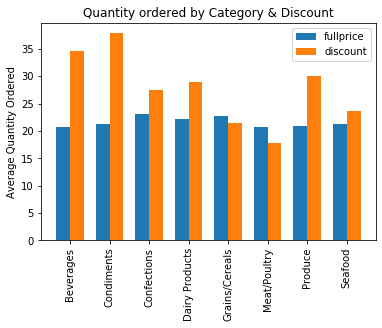

In [126]:
labels = list(df_pdd_gb.CategoryName.unique())
x = np.arange((len(labels)))
width = 0.35
fig, ax = plt.subplots()
fullprice = ax.bar(x - width/2, df_pdd_gb[df_pdd_gb.Discount == 0].Quantity, width, label='fullprice')
discount = ax.bar(x + width/2, df_pdd_gb[df_pdd_gb.Discount == 0.05].Quantity, width, label='discount')
ax.set_ylabel('Average Quantity Ordered')
ax.set_title('Quantity ordered by Category & Discount')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
plt.legend()
plt.show();

Overall, discounted items do have more quantity per order, with the exception of Grains/Cereals & Meat & Poultry.

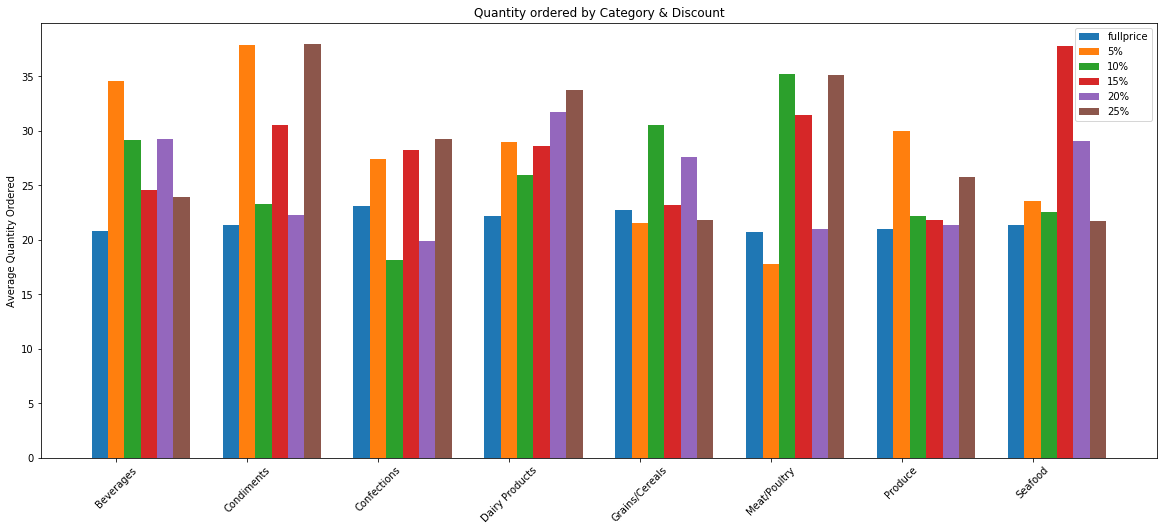

In [124]:
labels = list(df_pdd_gb.CategoryName.unique())
x = np.arange((len(labels)))
width = 1
fig, ax = plt.subplots(figsize=(20,8))
fullprice = ax.bar(x - width/8, df_pdd_gb[df_pdd_gb.Discount == 0].Quantity, width/8, label='fullprice')
discount_5 = ax.bar(x, df_pdd_gb[df_pdd_gb.Discount == 0.05].Quantity, width/8, label='5%')
discount_10 = ax.bar(x + (width/8), df_pdd_gb[df_pdd_gb.Discount == 0.1].Quantity, width/8, label='10%')
discount_15 = ax.bar(x + (width*2/8), df_pdd_gb[df_pdd_gb.Discount == 0.15].Quantity, width/8, label='15%')
discount_20 = ax.bar(x + (width*3/8), df_pdd_gb[df_pdd_gb.Discount == 0.2].Quantity, width/8, label='20%')
discount_25 = ax.bar(x + (width*4/8), df_pdd_gb[df_pdd_gb.Discount == 0.25].Quantity, width/8, label='25%')
ax.set_ylabel('Average Quantity Ordered')
ax.set_title('Quantity ordered by Category & Discount')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
plt.legend()
plt.show();

Taking a closer look Grains & Cereals do actually have some discount levels that are more than the full price (10% & 20 for grains/cereals and 10,15, and 20 for Meat & Poultry). So it does seem that the interaction between category & discount levels are significant.

### Hypothesis 5 - Interaction between Category ID and Discount

In [45]:
formula = 'Quantity ~ C(CategoryId) *  C(Discount)'
lm = ols(formula,df_product_detail).fit() 
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                                  sum_sq      df          F    PR(>F)
C(CategoryId)                2624.635863     7.0   1.069371  0.380554
C(Discount)                -44739.703475    10.0 -12.759993  1.000000
C(CategoryId):C(Discount)   39482.308867    70.0   1.608651  0.007618
Residual                   735961.498908  2099.0        NaN       NaN


The interaction between CategoryID and Discount is significant, if we consider a significance level of p<0.05. It makes sense that some perishable categories would have more or less ordered (such as produce).

## Next Steps

Other factors we might investigate are unit quantity as a possible factor. Each item has a vastly different unit size, with some containing multiple boxes, or boxes of cans. If one unit has a lot of the item, a customer might by fewer at one time regardless of a discount. In order to use quantity per item as a factor in predicting quantity ordered we would have to do some natural language processing to create a standard digit~units format. 

Another problem is that not all items need a lot of volume to last a while. For exmaples, a few boxes of pepper will last a while and won't buy a lot of units despite a discount. Other items are used in larger quantities, such as clam chowder or sodas, and are bought more frequently and are more likley purchased in greater quantities when discounted. Getting slightly better categories indicating perishables vs. non-perishable would also give better insight into which items to discount in order to encourage purchases.